# TP : Classification des survivants du Titanic

<center><img src=https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/RMS_Titanic_3.jpg/1280px-RMS_Titanic_3.jpg width=50%></center>  


[**Le TP est à faire de préférence sur Capytale**](https://capytale2.ac-paris.fr/web/c/5ee4-1148472). Sinon, utilisez Pyzo et télécharger [les données](https://raw.githubusercontent.com/cpge-itc/itc2/main/files/4_knn/tp_titanic/titanic.csv) (à mettre dans le même dossier que votre fichier Python).  

On souhaite prédire si un passager du Titanic a survécu ou non à l'accident, en utilisant l'algorithme des plus proches voisins. On pourra s'inspirer de l'[exemple du cours sur la classification des iris](https://cpge-itc.github.io/itc2/4_knn/exemple/knn_iris.html).

Voici les informations sur chaque passager :  
- `Survived` : 0 = Non, 1 = Oui
- `Pclass` : Classe de ticket (1 = 1ère classe, 2 = 2ème, 3 = 3ème)  
- `Sex` : Genre du passager (`male` ou `female`)  
- `Age` : Âge du passager (en années)  
- `Fare` : Tarif du ticket (en dollars)

## Chargement des données avec pandas

pandas est un module Python qui permet de manipuler des données sous forme de tableau appelé **DataFrame** (qui ressemble à un peu à une table SQL) :

In [1]:
import pandas as pd

df = pd.read_csv('titanic.csv') # df est un DataFrame
df.head() # pour afficher les 5 premières lignes

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


Ainsi `df` est un tableau contient 5 colonnes (`Survived`, `Pclass`, `Sex`, `Age`, `Fare`) et chaque ligne correspondant à un passager du Titanic. On peut obtenir le nombres de lignes avec `len(df)` :

In [2]:
len(df)

891


Chaque ligne est identifiée par un index (= nom de la ligne), ici $0, 1, 2, ...$. On peut accéder à la ligne d'indice $i$ avec `df.loc[i]` :

In [3]:
df.loc[0]

Survived       0
Pclass         3
Sex         male
Age         22.0
Fare        7.25
Name: 0, dtype: object

`df.loc[i]` donne en fait une series, qui peut être vu comme un tableau à une dimension.

On peut récupérer une colonne (également sous forme de series), par exemple `Age`, avec `df["Age"]` :

In [4]:
df["Age"]

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    28.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

On peut combiner ces deux méthodes pour récupérer une valeur précise, par exemple l'âge du 3ème passager :

In [5]:
df.loc[2, "Age"]

26.0

On peut aussi modifier une valeur avec, par exemple, `df.loc[2, "Age"] = ...`.

On peut parcourir les indices d'un dataframe avec `df.index`. Par exemple, pour trouver le passager le plus vieux :

In [6]:
maxi_age = 0
for i in df.index:
    if df.loc[i, "Age"] > maxi_age:
        maxi_age = df.loc[i, "Age"]
maxi_age

80.0

## Statistiques

**Question** : Écrire une fonction `moyenne(df, c)` qui renvoie la moyenne des valeurs sur la colonne `c` du dataframe `df`. Quelle est l'âge moyen des passagers du Titanic ? Le prix moyen du ticket ?

In [7]:
def moyenne(df, c):
    sum = 0
    for i in df.index:
        sum += df.loc[i, c]
    return sum/len(df)

print(f"l'age moyen des passagers est : {moyenne(df, 'Age')}")
print(f"l'age moyen des passagers est : {moyenne(df, 'Fare')}")

l'age moyen des passagers est : 29.36158249158249
l'age moyen des passagers est : 32.2042079685746


**Question** : Écrire une fonction `ecart_type(df, c)` qui renvoie l'écart-type des valeurs de la colonne `c` du dataframe `df`. On rappelle que l'écart-type d'une série de valeurs $x_1, \ldots, x_n$ est donné par : 

$$\sqrt{\frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2}$$

où $\bar{x}$ est la moyenne des valeurs $x_1, ..., x_n$.

**Remarque : On évitera de calculer plusieurs fois la même moyenne.**

In [8]:

def ecart_type(df, c):
    average = moyenne(df, c)
    sum = 0
    for i in df.index:
        sum += abs(df.loc[i, c] - average) ** 2
    return (sum / len(df)) ** (1 / 2)

In [9]:
ecart_type(df, "Age")

13.01238827279366

**Question** : Afficher le pourcentage de survivants parmi :
- les hommes
- les femmes
- les passagers de 1ère classe
- les passagers de 3ème classe

In [10]:
def pourcentage(df, c , attribut):
    nbr_survie = 0
    nbr_attribut = 0
    for i in df.index : 
        if df.loc[i, c] == attribut:
            nbr_attribut += 1
            if bool(df.loc[i, "Survived"]):
                nbr_survie += 1
    return (nbr_survie / nbr_attribut) * 100

print(f'pourcentage hommes survivant : {pourcentage(df, "Sex", "male")}')
print(f'pourcentage femmes survivant : {pourcentage(df, "Sex", "female")}')
print(f'pourcentage 1ere classe survivant : {pourcentage(df, "Pclass", 1)}')
print(f'pourcentage 3eme classe survivant : {pourcentage(df, "Pclass", 3)}')

pourcentage hommes survivant : 18.890814558058924
pourcentage hommes survivant : 74.20382165605095
pourcentage hommes survivant : 62.96296296296296
pourcentage hommes survivant : 24.236252545824847


## Variables catégorielles

Nous souhaitons modéliser chaque passager par un vecteur de $\mathbb{R}^4$ (car il y a $4$ informations pour chaque passager : âge, genre, classe et prix du ticket). Cependant, le genre est une variable catégorielle qu'il faut transformer en variable numérique :

In [11]:
df["Sex"] = df["Sex"].map({"male": 0, "female": 1}) # remplace male par 0 et female par 1
df.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,0,22.0,7.2500
1,1,1,1,38.0,71.2833
2,1,3,1,26.0,7.9250
3,1,1,1,35.0,53.1000
4,0,3,0,35.0,8.0500


## Standardisation

On remarque que les attributs sont sur des échelles très différentes (par exemple, l'âge est entre 0 et 80, alors que la classe du billet est entre 1 et 3).  
Les différences d'âge contribuent alors beaucoup plus dans les calculs de distance, ce qui ferait que l'âge aurait un poids plus important que la classe du billet pour la prédiction.  
Pour éviter cela, on va standardiser les données, c'est-à-dire les transformer de manière à ce que chaque attribut ait une moyenne nulle et un écart-type égal à 1.  

Si un attribut $x$ a une moyenne $\bar{x}$ et un écart-type $\sigma$, on peut le standardiser en le remplaçant par :

$$\frac{x - \bar{x}}{\sigma}$$

**Question** : Écrire une fonction `standardiser(df, c)` qui standardise la colonne `c` du dataframe `df`. L'utiliser pour standardiser les colonnes `Age`, `Fare`, `Pclass` et `Sex`. On rappelle qu'on peut modifier l'élément sur la ligne `i` et la colonne `c` avec `df.loc[i, c] = ...`.

In [12]:
def standardiser(df, c):
    average = moyenne(df, c)
    std = ecart_type(df, c)
    for i in df.index:
        df.loc[i, c] = (df.loc[i, c] - average) / std

In [13]:
for c in ["Age", "Fare", "Pclass", "Sex"]:
    standardiser(df, c)
df.head()

,Survived,Pclass,Sex,Age,Fare
0,0,0.827377,-0.737695,-0.565736,-0.502445
1,1,-1.566107,1.355574,0.663861,0.786845
2,1,0.827377,1.355574,-0.258337,-0.488854
3,1,-1.566107,1.355574,0.433312,0.420730
4,0,0.827377,-0.737695,0.433312,-0.486337


## Distance

Pour la question suivante, on rappelle comment accéder aux attributs d'une donnée :

In [14]:
p = df.loc[0] # 1er passager
p["Age"], p["Fare"], p["Pclass"], p["Sex"] # attributs de p

(-0.565736461074875,
 -0.5024451714361915,
 0.8273772438659676,
 -0.7376951317802897)

**Question** : Écrire une fonction `distance(p1, p2)` qui calcule la distance euclidienne entre les passagers `p1` et `p2`. On prendra en compte tous les attributs sauf `Survived`.

In [15]:
def distance(p1, p2):
    dist = 0
    attributs = ["Age", "Sex", "Fare", "Pclass"]
    for attribut in attributs:
        dist += (p1[attribut] - p2[attribut]) ** 2
    return dist ** (1 / 2 )

In [16]:
distance(df.loc[0], df.loc[1]) # distance entre les deux premiers passagers

3.6448209962213958

## Séparation des données

On sépare les données en deux : une partie `train` utilisée pour la prédiction, et une partie `test` utilisée pour évaluer la qualité de la prédiction :

In [17]:
train = df.sample(frac=0.8,random_state=0)
test = df.drop(train.index)
print("nombre de données dans train :", len(train))
print("nombre de données dans test :", len(test))

nombre de données dans train : 713
nombre de données dans test : 178


## Algorithmes des plus proches voisins

**Question** : Écrire une fonction `voisins(x, k)` qui renvoie les indices des $k$ plus proches voisins de `x` dans `train`.

In [18]:
def voisins(x, k):
# renvoie les k plus proches voisins de x dans X
    indices = sorted(train.index, key=lambda i: distance(x, train.loc[i]))
    return indices[:k]

In [19]:
voisins(test.iloc[0], 5)

[446, 651, 546, 427, 389]

**Question** : Écrire une fonction `plus_frequent(L)` qui renvoie l'élément le plus fréquent d'une liste `L`.

In [20]:
def plus_frequent(L):
    compteur = {}
    for e in L:
        compteur[e] = compteur.get(e, 0) + 1
    return max(compteur, key = compteur.get)

In [21]:
plus_frequent([2, 1, 5, 1, 2, 5, 5])

5

**Question** : Écrire une fonction `knn(x, k)` qui renvoie la prédiction de survie de `x` en utilisant l'algorithme des $k$ plus proches voisins.

In [22]:
def knn(x, k):
    nn = voisins(x, k)
    # freq_max = plus_frequent(nn)
    # return train.loc[freq_max]
    return plus_frequent([train.loc[i, "Survived"] for i in nn])

In [23]:
knn(test.iloc[0], 5)

1

## Analyse des résultats

**Question** : Écrire une fonction `precision(k)` qui renvoie la précision de l'algorithme des $k$ plus proches voisins en utilisant `k` voisins.

In [24]:
def precision(k):
    compteur = 0
    for i in test.index:
        if knn(test.loc[i], k) == test.loc[i, "Survived"]:
            compteur += 1
    return compteur / len(test)

In [25]:
precision(3)

0.797752808988764

**Question** : Écrire une fonction `plot_precision(kmax)` qui trace la précision pour $k$ variant de $1$ à `kmax`. Quelle est la meilleure précision obtenue ? Quelle est le nombre de voisins optimal ?

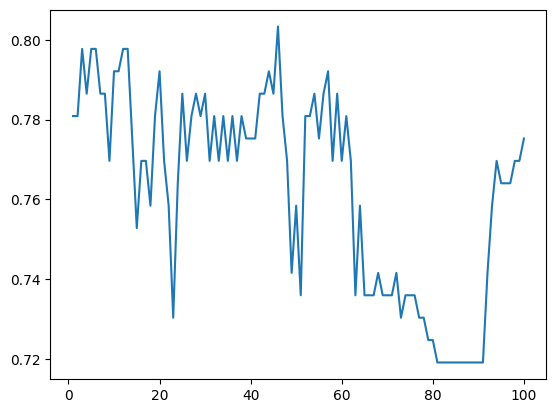

In [26]:
import matplotlib.pyplot as plt 

def plot_precision(kmax):
    k_values = list(range(1, kmax + 1))
    precision_values = [precision(i) for i in k_values]
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(k_values, precision_values)
    plt.show()

plot_precision(100)

## Kaggle

Ce TP provient d'une compétition Kaggle : [Titanic: Machine Learning from Disaster](www.kaggle.com/c/titanic).  
Avec KNN, j'obtiens un score de $\approx 0.763$... Ce qui n'est pas terrible car l'exemple de submission basée uniquement sur le genre donne un score de $\approx 0.765$.

**Question** : Soumettre le fichier `submission.csv` obtenu par le code ci-dessus sur [Kaggle](https://www.kaggle.com/competitions/titanic/submissions) et essayer d'obtenir un score plus élevé. On pourra essayer d'implémenter les améliorations suggérées à la [fin du cours](https://cpge-itc.github.io/itc2/4_knn/exemple/knn_iris.html).

In [28]:
submission = pd.read_csv('test.csv')
for c in "Age", "Fare":
    submission[c].fillna(submission[c].median(), inplace=True)
submission["Sex"] = submission["Sex"].map({"male": 0, "female": 1})
for c in ["Age", "Fare", "Pclass", "Sex"]:
    standardiser(submission, c)
    
submission["Survived"] = [knn(submission.iloc[i], 5) for i in range(len(submission))]

submission[["PassengerId", "Survived"]].to_csv('submission.csv', index=False)